# Image Caption Generation


## Text preparation 

Before moving onto the actual model, we first have to prepare the text.
First step is to build a vocabulary.

Resnet- pre-trained network.

CNN- to extract features using resnet.
Then we pass it to the next part- Recursive Neural Network.

5 different people describing and image. 





In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8k_Dataset/" 
caption_dir = root + "captions/"                     
image_dir = root + "images/"                          


token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        if "2258277193_586949ec62" not in line.strip():     
          lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [0]:
lines[:5]

In [0]:

class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}    #two dictionaries because it's more efficient. if the word is not in dict it will add it
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

We extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```




In [163]:
image_id_list=[]
image_desc_list=[]

for line in lines:
    tokens = line.split()
    image_id, image_desc=tokens[0], tokens[1:]
    image_id_list.append(image_id)
    image_desc_list.append(image_desc)

words=[[char.lower() for char in val] for val in image_desc_list]

from string import punctuation

symbols=list(punctuation)

words = [[c for c in char if c not in symbols] for char in words]
print(words[:10])


from collections import Counter
# count each element in a list (like after unnesting them))
freq=Counter([x for a in words for x in a])


# delete elements in sublist is they appear less than 3 times in a whole text
words_frequent = [[ele for ele in char if freq[ele] > 3] for char in words]
print(len(words_frequent))


# create a whole big unnested list
words_list = [ item for elem in words_frequent for item in elem]

#check how many distinctive values are there
print(len(set(words_list)))

[['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way'], ['a', 'girl', 'going', 'into', 'a', 'wooden', 'building'], ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse'], ['a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse'], ['a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin'], ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting'], ['a', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road'], ['a', 'black', 'dog', 'and', 'a', 'white', 'dog', 'with', 'brown', 'spots', 'are', 'staring', 'at', 'each', 'other', 'in', 'the', 'street'], ['two', 'dogs', 'of', 'different', 'breeds', 'looking', 'at', 'each', 'other', 'on', 'the', 'road'], ['two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other']]
40455
3430


We build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')


Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

We don't add words that appear three times or less.

In [9]:
for word in words_list:
  vocab.add_word(word)

print(len(vocab))


3434


## Dataset and loaders for training

Keeping the same order, we concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. We then store all the image ids in a list ```image_ids```.

In [10]:
#join each element of a list into a string
cleaned_captions=[" ".join(char) for char in words]
print(cleaned_captions[:5])

image_ids=image_id_list

image_ids=[x.split(".")[0] for x in image_ids]
print(image_ids[:10])


['a child in a pink dress is climbing up a set of stairs in an entry way', 'a girl going into a wooden building', 'a little girl climbing into a wooden playhouse', 'a little girl climbing the stairs to her playhouse', 'a little girl in a pink dress going into a wooden cabin']
['1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e', '1000268201_693b08cb0e', '1001773457_577c3a7d70', '1001773457_577c3a7d70', '1001773457_577c3a7d70', '1001773457_577c3a7d70', '1001773457_577c3a7d70']


The dataframe for the image paths and captions.

In [11]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}


data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

data_df['image_id'] == "2258277193_586949ec62"

data_df.loc[data_df['image_id'] == "2258277193_586949ec62"]

,image_id,path,caption


In [12]:
data_df.head(n=10)

,image_id,path,caption
0,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a girl going into a wooden building
2,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70,drive/My Drive/Colab Notebooks/ai_cw_2/Flickr8...,two dogs on pavement moving toward each other


This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):

        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])



Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5
import torch
train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)



Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    collate_fn=caption_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=5, 
    shuffle=False,
    num_workers=2,
    collate_fn=caption_collate_fn
)




## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)
        #self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        #hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size) # replaced with rnn
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids





In [150]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

Initialize the models and set the learning parameters.

In [0]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


A set of functions to generate sample captions displayed with images.


In [0]:
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import torch
import argparse
import pickle 
import os
from torchvision import transforms 
from PIL import Image

from torch.autograd import Variable

#!pip install q nltk==3.5
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

#print('The nltk version is {}.'.format(nltk.__version__))

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def imshow(inp, figsize=None, title=None):
    if figsize != None:
        plt.figure(figsize=figsize)
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

def get_sentence(caption_tensor): 
    # Convert word_ids to words
    sampled_caption = []
    for word_id in caption_tensor:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption[1:-1])
    return sentence

def transform():
  transformed_image = transforms.Compose([ 
  transforms.Resize(224),
  transforms.CenterCrop(224),  # Why do we choose 224 x 224?
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                        (0.229, 0.224, 0.225))])
  return transformed_image


def find_captions(caption_tensors):
    reference_captions = []

    for i in range(5):
      reference_captions.append(get_sentence(caption_tensors[i]))

    return reference_captions

def get_sample_2():
    score_list=[]
    test_iterator = iter(test_loader)
    encoder.eval()
    for i in range(2):
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)

      images = images.to(device)
      captions = captions.to(device)
      features = encoder(images)

      sample_ids = decoder.sample(features)
      sample_ids=sample_ids.cpu().numpy()
      generated_sentence=get_sentence(sample_ids[0])
      print(generated_sentence)
      
      true_ids = captions.cpu().numpy()
      sentence_true = find_captions(true_ids)

      #split the string into words to calculate bleu score for both true caption and generated caption
      # TRUE CAPTION SPLIT
      sentence_true_words=[ [i] for i in sentence_true]
      sentence_true_words=[ string[0].split() for string  in sentence_true_words]
      
      #GENERATED CAPTION SPLIT
      generated_sentence_words=list(generated_sentence.split())
   
      #calculate bleu score
      score = sentence_bleu(sentence_true_words, generated_sentence_words, weights=(0.45, 0.35, 0.10, 0.10), smoothing_function=SmoothingFunction().method7)
      print("Bleu score for generated caption: {}".format(score))

      out = make_grid(images[0])
      out=out.cpu()
      imshow(out, figsize=(10,6), title='Target: %s\nPrediction: %s' % (sentence_true, generated_sentence))

      score_list.append(score)
      
    encoder.train()
    return score_list


## TRAINING 

In [0]:


total_step = len(train_loader)

#uncomment when running RNN
# bleu_scoreRNN_list =[]
# loss_rnn=[]


bleu_scoreLSTM_list=[]
loss_lstm=[]

file_name = "checkpoint.pth"

print("__________________Before training__________________")
get_sample_2()

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)

        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item()))

    #     if (i+1) % save_step == 0:
    #       torch.save(encoder.state_dict(), file_name + '-RNNencoder.ckpt')
    #       torch.save(decoder.state_dict(), file_name + '-RNNdecoder.ckpt')
    # print('Generated captions after epoch: {}'.format(epoch+1))
    x=get_sample_2()


    # bleu_scoreRNN_list.append(x)
    # loss_rnn.append(loss.item(x))


    bleu_scoreLSTM_list.append(x)
    loss_lstm.append(loss.item(x))

                    


In [0]:
score1RNN=[el[0] for el in bleu_scoreRNN_list]
score2RNN=[el[1] for el in bleu_scoreRNN_list]  


score1LSTM=[el[0] for el in bleu_scoreLSTM_list]
score2LSTM=[el[1] for el in bleu_scoreLSTM_list]  



In [0]:
# bleu score for first image rnn [0.5153939645243383, 0.5782537389840694, 0.5105593001127932, 0.45272728894361675, 0.6022782201270712]
# bleu score for second image rnn [0.5019846346860442, 0.42427489304239147, 0.6442534123707138, 0.4723402003873197, 0.4465502347955529]
# loss rnn [2.8743698596954346, 2.7102692127227783, 2.702296733856201, 2.4979448318481445, 2.552945137023926]


Loss plotting 

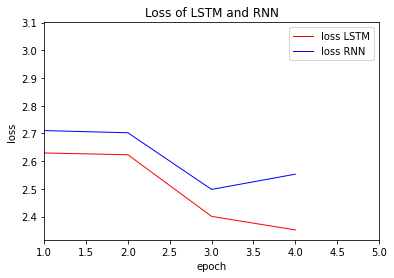

In [64]:


def plot_loss(loss_lstm, loss_rnn):
    x = np.arange(0, 5)

    plt.figure()
    plt.plot(x, loss_lstm, "r", linewidth=1, label="loss LSTM")

    plt.plot(x, loss_rnn, "b", linewidth=1, label="loss RNN")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss of LSTM and RNN")
    plt.legend()
    plt.show()
    
plot_loss(loss_lstm, loss_rnn)

##Model's evaluation

In [0]:

# GENERATE SAMPLE OF 5 IMAGES ALONG WITH CAPTIONS AND BLEU SCORES

def get_sample_5():
    generated_list=[]
    test_iterator = iter(test_loader)
    encoder.eval()
    for i in range(5):
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images, captions, lengths = next(test_iterator)
      images = images.to(device)
      captions = captions.to(device)
      features = encoder(images)
      print()

      sample_ids = decoder.sample(features)
      sample_ids=sample_ids.cpu().numpy()
      generated_sentence=get_sentence(sample_ids[0])
      
      true_ids = captions.cpu().numpy()
      sentence_true = find_captions(true_ids)

      #split the string into words to calculate bleu score for both true caption and generated caption
      # TRUE CAPTION SPLIT
      sentence_true_words=[ [i] for i in sentence_true]
      sentence_true_words=[ string[0].split() for string  in sentence_true_words]
      #print(sentence_true_words)
      
      #GENERATED CAPTION SPLIT
      generated_sentence_words=list(generated_sentence.split())
   
      #calculate bleu score
      score = sentence_bleu(sentence_true_words, generated_sentence_words, weights=(0.45, 0.35, 0.1, 0.1), smoothing_function=SmoothingFunction().method7) 
      print("Bleu score for generated caption: {}".format(score))

      #display image
      out = make_grid(images[0])
      out=out.cpu()
      imshow(out, figsize=(10,6), title='Target: %s\nPrediction: %s' % (sentence_true, generated_sentence))
      generated_list.append(generated_sentence)

    encoder.train()
    return generated_list


get_sample_5()

In [156]:
#calculate Bleu score over the whole test set

def bleu_score_test():
  score_total=0
  for i, (images, captions, lengths) in enumerate(test_loader):
    images = images.to(device)
    captions = captions.to(device)
    features = encoder(images)
    encoder.eval()

    sample_ids = decoder.sample(features)
    sample_ids=sample_ids.cpu().numpy()
    generated_sentence=get_sentence(sample_ids[0])
    
    true_ids = captions.cpu().numpy()
    sentence_true = find_captions(true_ids)

    sentence_true_words=[ [i] for i in sentence_true]
    sentence_true_words=[ string[0].split() for string  in sentence_true_words]

    generated_sentence_words=list(generated_sentence.split())
  
    #calculate bleu score
    score = sentence_bleu(sentence_true_words, generated_sentence_words, weights=(0.45, 0.35, 0.1, 0.1), smoothing_function=SmoothingFunction().method7) 
    #print("Bleu score for generated caption: {}".format(score))

    score_total+=score
  print(score_total/len(test_loader))
  
  
    

bleu_score_test()

0.48773541110981267


In [157]:
# CALCULATES PERFORMANCE ON SHORT VS LONG CAPTIONS

from nltk import flatten

def long_short():
  long_caption_generated=[]
  long_caption_ref=[]
  short_caption_generated=[]
  short_caption_ref=[]
  for i, (images, captions, lengths) in enumerate(test_loader):
    images = images.to(device)
    captions = captions.to(device)
    features = encoder(images)
    encoder.eval()

    sample_ids = decoder.sample(features)
    sample_ids=sample_ids.cpu().numpy()
    generated_sentence=get_sentence(sample_ids[0])
    
    true_ids = captions.cpu().numpy()
    sentence_true = find_captions(true_ids)

    sentence_true_words=[ [i] for i in sentence_true]
    sentence_true_words=[ string[0].split() for string  in sentence_true_words]

    generated_sentence_words=list(generated_sentence.split())

    gen_len=len(generated_sentence_words)
    true_len=len(flatten(sentence_true_words))/5

    if gen_len > true_len :
      long_caption_generated.append(generated_sentence_words)
      long_caption_ref.append(sentence_true_words)
    else:
      short_caption_generated.append(generated_sentence_words)
      short_caption_ref.append(sentence_true_words)


  bleu_score_long=corpus_bleu(long_caption_ref, long_caption_generated, weights=(0.45, 0.35, 0.1, 0.1), smoothing_function=SmoothingFunction().method7)
  bleu_score_short=corpus_bleu(short_caption_ref, short_caption_generated,weights=(0.45, 0.35, 0.1, 0.1), smoothing_function=SmoothingFunction().method7)
    
  print("Number of short captions:{}".format(len(short_caption_generated)))
  print("Number of long captions:{}".format(len(long_caption_generated)))

    
  print("Bleu score for short caption: {}".format(bleu_score_short))
  print("Bleu score for long caption: {}".format(bleu_score_long))

long_short()

Number of short captions:233
Number of long captions:172
Bleu score for short caption: 0.4259603787052534
Bleu score for long caption: 0.38259930514032164
